In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install pysam to work with vcf files
!pip install pysam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 18.6 MB/s eta 0:00:00


In [27]:
import pysam
import os
import pandas as pd

In [29]:
# step 1 : save ID and pos of all varients in a list
vcf_directory = '/content/drive/MyDrive/Mode of Inheritance Task/Mode of Inheritance Task files/vcf_files'
ID_list = []
pos_list = []
for filename in os.listdir(vcf_directory):
  vcf_path = os.path.join(vcf_directory, filename)
  vcf_file = pysam.VariantFile(vcf_path)
  for variant in vcf_file:
    ID_list.append(variant.id)
    pos_list.append(variant.pos)
  vcf_file.close()


In [32]:
# step 2 : create a csv file temp_output.csv

csv_data = {'ID': ID_list,
            'pos': pos_list,

            'symbol_OMIM': [None for i in range(len(ID_list))],
            'MOI_OMIM': [None for i in range(len(ID_list))],

            'symbol_CGD': [None for i in range(len(ID_list))],
            'MOI_CGD': [None for i in range(len(ID_list))],

            'symbol_ClinGen': [None for i in range(len(ID_list))],
            'MOI_ClinGen': [None for i in range(len(ID_list))],

            'symbol_gene2phenotype': [None for i in range(len(ID_list))],
            'MOI_gene2phenotype': [None for i in range(len(ID_list))],

            'symbol_GenCC': [None for i in range(len(ID_list))],
            'MOI_GenCC': [None for i in range(len(ID_list))],

            'P_AD': [None for i in range(len(ID_list))]}

df = pd.DataFrame(csv_data)

df.to_csv('/content/drive/MyDrive/Mode of Inheritance Task/Mode of Inheritance Task files/temp_output.csv', index=False)

In [ ]:
len(pos_list)

22554

In [ ]:
import pandas as pd

# Specify the file path
file_path = "/content/drive/MyDrive/Mode of Inheritance Task/Mode of Inheritance Task files/databases/OMIM_genemap2_chr17.txt"

# Read the text file into a DataFrame, skipping initial rows starting with #
data = pd.read_csv(file_path, delimiter='\t', comment='#')


In [ ]:
# Display the DataFrame
data.head(5)

,Chromosome,Genomic Position Start,Genomic Position End,Cyto Location,Computed Cyto Location,MIM Number,Gene/Locus And Other Related Symbols,Gene Name,Approved Gene Symbol,Entrez Gene ID,Ensembl Gene ID,Comments,Phenotypes,Mouse Gene Symbol/ID
0,chr17,1,10800000,17p13,NaN,608631,ASPG2,"Asperger syndrome, susceptibility to, 2",NaN,431711.0,NaN,breakpoints between CHRNE and GP1BA,"{Asperger syndrome susceptibility 2}, 608631 (...",NaN
1,chr17,1,3400000,17p13.3,NaN,113721,BCPR,Breast cancer-related regulator of TP53,NaN,NaN,NaN,NaN,Breast cancer (1),NaN
2,chr17,1,10800000,17p13,NaN,601202,"CTRCT24, CTAA2","Cataract 24, anterior polar",NaN,1484.0,NaN,NaN,"Cataract 24, anterior polar, 601202 (2), Autos...",NaN
3,chr17,1,3400000,17p13.3,NaN,615674,DDD3,Dowling-Degos disease 3,NaN,102997065.0,NaN,max lod at D17S1529,"Dowling-Degos disease 3, 615674 (2), Autosomal...",NaN
4,chr17,1,3400000,17p13.3,NaN,613215,"DUP17p13.3, C17DUPp13.3",Chromosome 17p13.3 duplication syndrome,NaN,NaN,NaN,includes LIS1 and/or YWHAE,"Chromosome 17p13.3 duplication syndrome, 61321...",NaN


In [ ]:
gene_interval_list = [(data['Genomic Position Start'][i], data['Genomic Position End'][i]) for i in range(len(data))]

In [ ]:
pos_index_dict = {}
for pos in pos_list:
  index_list = []
  for i ,(start, end) in enumerate(gene_interval_list):
    if start <= pos <= end:
      index_list.append(i)
  pos_index_dict[pos] = index_list

In [ ]:
count = 0
for pos in pos_index_dict.keys():
  if count <= 10:
    print(pos,': ',pos_index_dict[pos])
    count += 1

137603 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 1065, 1066]
138213 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 1065, 1066]
261904 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 1065, 1066]
321346 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 1065, 1066]
410351 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 1065, 1066]
413503 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 1065, 1066]
562535 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 1065, 1066]
562753 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 1065, 1066]
733080 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 1065, 1066]
744946 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 1065, 1066]
745827 :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 1065, 1066]


In [ ]:
pos_phenotype_dict = {}
for pos in pos_list:
  phenotype_list = []
  for index in pos_index_dict[pos]:
    phenotype_list.append(data['Phenotypes'][index])
  pos_phenotype_dict[pos] = phenotype_list

In [ ]:
count = 0
for pos in pos_phenotype_dict.keys():
  if count <= 10:
    print(pos,': ',pos_phenotype_dict[pos])
    count += 1

137603 :  ['{Asperger syndrome susceptibility 2}, 608631 (2), Multifactorial, Isolated cases', 'Breast cancer (1)', 'Cataract 24, anterior polar, 601202 (2), Autosomal dominant', 'Dowling-Degos disease 3, 615674 (2), Autosomal dominant', 'Chromosome 17p13.3 duplication syndrome, 613215 (4)', 'Miller-Dieker lissencephaly syndrome, 247200 (4), Autosomal dominant', 'Nail disorder, nonsyndromic congenital, 7, 605779 (2), Autosomal dominant', 'Split-hand/foot malformation with long bone deficiency 3, 612576 (4), Autosomal dominant', '[Sex hormone-binding globulin circulating level QTL 1], 613498 (2)', nan, '{Opioid dependence, susceptibility to, 1}, 610064 (2)']
138213 :  ['{Asperger syndrome susceptibility 2}, 608631 (2), Multifactorial, Isolated cases', 'Breast cancer (1)', 'Cataract 24, anterior polar, 601202 (2), Autosomal dominant', 'Dowling-Degos disease 3, 615674 (2), Autosomal dominant', 'Chromosome 17p13.3 duplication syndrome, 613215 (4)', 'Miller-Dieker lissencephaly syndrome, 24

In [ ]:
pos_MOIlist_dict = {}
for pos in pos_list:
  MOI_list = []
  for phenotype in pos_phenotype_dict[pos]:
    if "dominant" in str(phenotype).lower() and "recessive" in str(phenotype).lower():
      MOI_list.append('AD/AR')
    elif "dominant" in str(phenotype).lower():
      MOI_list.append('AD')
    elif "recessive" in str(phenotype).lower():
      MOI_list.append('AR')
    else:
      MOI_list.append('')
  pos_MOIlist_dict[pos] = MOI_list

In [ ]:
count = 0
for pos in pos_MOIlist_dict.keys():
  if count <= 10:
    print(pos,': ',pos_MOIlist_dict[pos])
    count += 1

137603 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '']
138213 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '']
261904 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '', '']
321346 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '', '']
410351 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '']
413503 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '']
562535 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', 'AR', '', '']
562753 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', 'AR', '', '']
733080 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', '', '', '']
744946 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', 'AR', '', '']
745827 :  ['', '', 'AD', 'AD', '', 'AD', 'AD', 'AD', '', 'AR', '', '']


In [ ]:
for pos in range(4898000, 4899965):
  if pos in pos_list:
    print(pos, ' : ', pos_MOIlist_dict[pos])

4898816  :  ['', 'AD', 'AD', 'AD', '', 'AR', 'AD/AR', '', '']
4898960  :  ['', 'AD', 'AD', 'AD', '', 'AR', 'AD/AR', '', '']
4899034  :  ['', 'AD', 'AD', 'AD', '', 'AR', 'AD/AR', '', '']
4899390  :  ['', 'AD', 'AD', 'AD', '', 'AR', 'AD/AR', '', '']
4899534  :  ['', 'AD', 'AD', 'AD', '', 'AR', 'AD/AR', '', '']


In [ ]:
def determine_MOI(MOI_list):
    # Remove empty strings from MOI list
    filtered_MOI_list = [MOI for MOI in MOI_list if MOI]

    if not filtered_MOI_list:
        return 'Unknown'

    if len(set(filtered_MOI_list)) == 1:
        return filtered_MOI_list[0]

    # If both 'AD' and 'AR' present, assign 'AD/AR'
    if 'AD' in filtered_MOI_list and 'AR' in filtered_MOI_list:
        return 'AD/AR'

    # Handle conflicting MOIs
    return 'Mixed/Uncertain'

# Determine MOI for each variant

In [ ]:
# Determine MOI for each variant
pos_MOI_dict = {}
for pos, MOI_list in pos_MOIlist_dict.items():
    MOI = determine_MOI(MOI_list)
    pos_MOI_dict[pos] = MOI

In [ ]:
# Print variant MOIs
for pos, MOI in pos_MOI_dict.items():
    print(f"Variant at position {pos}: MOI = {MOI}")

In [ ]:
for pos, MOI in pos_MOI_dict.items():
  if MOI == 'AR':
    print(pos)

27301794
27303362
27312362
27311633
27312303


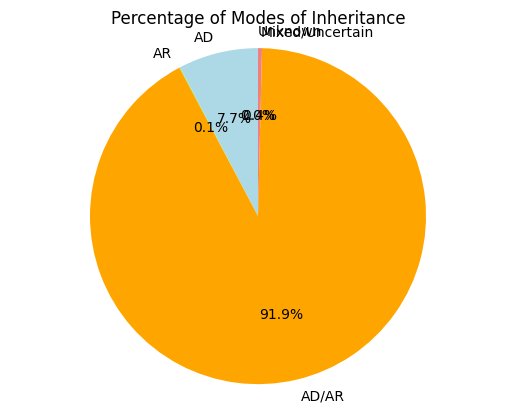

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each MOI
MOIs_count = {'AD': 0, 'AR': 0, 'AD/AR': 0, 'Mixed/Uncertain': 0, 'Unknown': 0}

# Count occurrences of each MOI
for MOI in pos_MOI_dict.values():
    MOIs_count[MOI] += 1

# Convert counts to percentages
total_variants = sum(MOIs_count.values())
percentages = [count / total_variants * 100 for count in MOIs_count.values()]

# Define MOIs and colors
MOIs = list(MOIs_count.keys())
colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral', 'lightgrey']

# Create figure and axis
fig, ax = plt.subplots()

# Plot circle
circle = plt.Circle((0, 0), 0.7, color='white')
ax.add_artist(circle)

# Plot pie chart
ax.pie(percentages, labels=MOIs, autopct='%1.1f%%', startangle=90, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add title
plt.title('Percentage of Modes of Inheritance')

# Show plot
plt.show()


In [ ]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez

# Entrez email address (required by NCBI)
Entrez.email = "alihajisadeghian250@gmail.com"

# Entrez Gene ID of the gene you're interested in
entrez_gene_id = "2"

# Query Entrez Gene database to retrieve gene information
handle = Entrez.efetch(db="gene", id=entrez_gene_id, rettype="gb", retmode="text")
gene_record = handle.read()
handle.close()


In [ ]:
gene_record

'\n1. A2M\nOfficial Symbol: A2M and Name: alpha-2-macroglobulin [Homo sapiens (human)]\nOther Aliases: A2MD, CPAMD5, FWP007, S863-7\nOther Designations: alpha-2-macroglobulin; C3 and PZP-like alpha-2-macroglobulin domain-containing protein 5; alpha-2-M\nChromosome: 12; Location: 12p13.31\nAnnotation: Chromosome 12 NC_000012.12 (9067708..9116229, complement)\nMIM: 103950\nID: 2\n\n'

In [ ]:
chr = int(gene_record.split('\n')[5].split(' ')[1].split(';')[0])

In [ ]:
start_pos = int(gene_record.split('\n')[6].split('(')[1].split('..')[0])

In [ ]:
end_pos = int(gene_record.split('\n')[6].split('(')[1].split('..')[1].split(',')[0].split(')')[0])

In [ ]:
chr

12

In [ ]:
start_pos

9067708

In [ ]:
end_pos

9116229